In [16]:
# FWHM vs peak time
# Write text
# Write TEST functions
# check fano calc and check fano in knoll. ~0.12
# fix smaple notebook
# add fano factor error
# AM TEXT FILE IS ACTUALLY CO

In [17]:
%run ./lab1_analysis_functions.py

In [18]:
tenevents = read_ten_event_file()

M = find_M_value(tenevents)
print('M ', M)

('M ', 4445.9118105773478)


In [19]:
tenevents = read_ten_event_file()
ndata = len(tenevents)
nsamples = 4096
x_values = np.linspace(0, nsamples, nsamples)
tenevents = fast_baseline_correction(tenevents)
plt.figure()
plt.cla()
plt.clf()
for event in tenevents[0:5]:
    plt.plot(event)
plt.xlim([950, 1020])
plt.title('Raw Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('../figures/tenevents_rawdata.pdf')
# plt.show()

k = 100
m = 100

plt.figure()
plt.cla()
plt.clf()
for event in tenevents[0:5]:
    event = fast_trapezoidal_filter(event, k, m, M=4400)
    plt.plot(x_values, event)
plt.xlim([950, 1325])
plt.title('Filtered Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('../figures/tenevents_filtered.pdf')
# plt.show()

In [20]:
filename = '../data/Am_pulser_real.h5'
am_raw_data = import_data(filename)

filename = '../data/Cs_pulser_real.h5'
cs_raw_data = import_data(filename)

filename = '../data/Co_pulser_real.h5'
co_raw_data = import_data(filename)

In [21]:
cs_baseline = np.mean(cs_raw_data[:len(cs_raw_data),0:799],1).reshape((len(cs_raw_data),1))
cs_baseline_corrected_signals = cs_raw_data[:len(cs_raw_data),] - cs_baseline

In [22]:
# M = find_M_value(cs_baseline_corrected_signals[0:len(cs_raw_data)])
M = 5920.5649833
optimal_M = M
print('optimal M: ', M)

('optimal M: ', 5920.5649833)


In [23]:
# OPTIMIZE GAP TIME

m_values = np.linspace(0, 100, 30)
k = 100

number_of_events = len(cs_raw_data)
#number_of_events = 10000
assert number_of_events <= len(cs_raw_data)
ndata = 4096

m_fwhm_values = []
m_values_ns = []
m_fwhm_values_err = []

for m in m_values:
    m = int(m)
    m_values_ns.append(m * 10)
    
    cs_nrgs=[]
    cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
    nbins = 2048
    cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0,512]) #, range=Cs_range) # WORKS
    cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    cs_fwhm, cs_center, err = fit_gaussian_peak_linear_background(cs_bins[1000:2000], cs_counts[1000:2000])
    m_fwhm_values_err.append(err* 100 / cs_peak_center)
    m_fwhm_values.append(round(cs_fwhm / cs_center, 7) * 100)

In [ ]:
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (%)')
plt.errorbar(m_values_ns, m_fwhm_values, yerr=m_fwhm_values_err, ecolor='b')
plt.plot(m_values_ns, m_fwhm_values, 'o-b')
plt.title('Gap vs Energy Resolution')
plt.savefig('../figures/gap_optimization_cs.pdf')
# plt.show()

plt.figure()
plt.cla()
plt.clf()
m_diff_list = abs(np.diff(m_fwhm_values))
plt.plot(m_values_ns[0:-1], m_diff_list, '-')
# plt.show()

In [26]:
optimal_gap_time =  int(m_values_ns[np.argmin(m_fwhm_values)]) / 10
m = optimal_gap_time 
print('optimal gap time: ' + str(m * 10))

optimal gap time: 420


In [27]:
# OPTIMIZE PEAKING TIME

k_values = np.logspace(np.log10(10), np.log10(2000), 10, endpoint=True, base=10)
number_of_events = len(cs_raw_data)
assert number_of_events <= len(cs_raw_data)

k_fwhm_values = []
k_fwhm_values_err = []
k_fwhm_pulser_values = []
k_values_ns = []
m = 25

nbins = 2048

for k in k_values:
    k = int(k)
    k_values_ns.append(k * 10)
    
    cs_nrgs=[]
    cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
    
    cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0,512])
    cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    cs_bins = cs_bins[1000:2000]
    cs_counts = cs_counts[1000:2000]
   # plt.plot(cs_bins, cs_counts)
   # plt.show()
    cs_peak_fwhm, cs_peak_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)

    k_fwhm_values.append(round(cs_peak_fwhm / cs_peak_center, 7) * 100)
    k_fwhm_values_err.append(err * 100 / cs_peak_center)

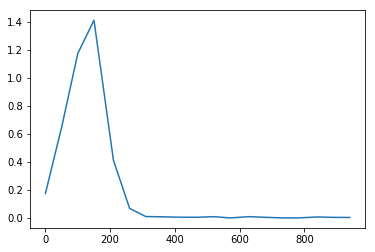

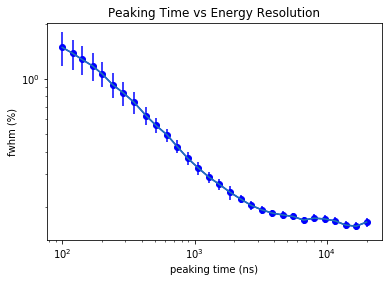

In [46]:
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('peaking time (ns)')
plt.ylabel('fwhm (%)')
plt.loglog(k_values_ns, k_fwhm_values, 'o-b')
plt.errorbar(k_values_ns, k_fwhm_values, yerr=k_fwhm_values_err, ecolor='b')
plt.title('Peaking Time vs Energy Resolution')
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
#plt.savefig('../figures/peak_optimization_cs137.pdf')
#plt.show()

In [47]:
optimal_peaking_time = k_values_ns[np.argmin(k_fwhm_values)] / 10
# k = 50
k = optimal_peaking_time
print('optimal peaking time: ', k)

('optimal peaking time: ', 1666)


In [30]:
# Final Filter Paramters
print("========  Final Filter Parameters  ========")
print(' gap time (m)     = ' + str(m * 10) + ' ns')
print(' peaking time (k) = ' + str(k * 10) + ' ns')
print(' decay time (M)   = ' + str(round(M / 10,2)) + ' ns')
print("===========================================")

save_parameters(m * 10 , k * 10 , M / 10)

========  Final Filter Parameters  ========
 gap time (m)     = 420 ns
 peaking time (k) = 16660 ns
 decay time (M)   = 592.06 ns


In [56]:
cs_baseline = np.mean(cs_raw_data[:len(cs_raw_data),0:799],1).reshape((len(cs_raw_data),1))
cs_baseline_corrected_signals = cs_raw_data[:len(cs_raw_data),] - cs_baseline

am_baseline = np.mean(am_raw_data[:len(am_raw_data),0:799],1).reshape((len(am_raw_data),1))
am_baseline_corrected_signals = am_raw_data[:len(am_raw_data),] - am_baseline

co_baseline = np.mean(co_raw_data[:len(co_raw_data),0:799],1).reshape((len(co_raw_data),1))
co_baseline_corrected_signals = co_raw_data[:len(co_raw_data),] - co_baseline

cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
co_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, co_baseline_corrected_signals, k, m, M)
am_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, am_baseline_corrected_signals, k, m, M)

In [57]:
%run ./lab1_analysis_functions.py

In [41]:
make_nrg_sample_file(co_nrgs[0:len(co_nrgs)], '../data/co_energies.txt')
make_nrg_sample_file(cs_nrgs[0:len(cs_nrgs)], '../data/cs_energies.txt')
make_nrg_sample_file(am_nrgs[0:len(am_nrgs)], '../data/am_energies.txt')

In [ ]:
# GET ENERGY RESOLUTION FOR DIFFERENT PEAKS

fwhm_peak_values = []
fwhm_peak_energies = []
fwhm_pulser_values = []
peak_err = []
pulser_err = []

# AM-241
am_counts, bin_edges = np.histogram(am_nrgs, bins=2048, range=[0, 400])
am_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
am_bins = am_bins[10:250] 
am_counts = am_counts[10:250]
peak_fwhm, peak_center ,err = fit_gaussian_peak_linear_background(am_bins, am_counts)
fwhm_peak_values.append(round(peak_fwhm / peak_center, 7) * 100)
fwhm_peak_energies.append(59.536)
peak_err.append(err * 100 / peak_center)

# AM-PULSER

am_counts, bin_edges = np.histogram(am_nrgs, bins=2048, range=[0, 400])
am_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
am_bins = am_bins[1000:2000] 
am_counts = am_counts[1000:2000]
pulser_fwhm, pulser_center ,err = fit_gaussian_peak_linear_background(am_bins, am_counts)
fwhm_pulser_values.append(round(pulser_fwhm / pulser_center, 7) * 100)
pulser_err.append(err* 100 / pulser_center)

# CS-662
cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0, 512])
cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
cs_bins = cs_bins[1000:2000]
cs_counts = cs_counts[1000:2000]
cs_peak_fwhm, cs_peak_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)

fwhm_peak_values.append(round(cs_peak_fwhm / cs_peak_center, 7) * 100)
fwhm_peak_energies.append(661.615)
peak_err.append(err* 100 / cs_peak_center)

# CS-PULSER
cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[900, 900+512])
cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
cs_bins = cs_bins[100:1000]
cs_counts = cs_counts[100:1000]
cs_pulser_fwhm, cs_pulser_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)
fwhm_pulser_values.append(round(cs_pulser_fwhm / cs_pulser_center, 7) * 100)
pulser_err.append(err * 100 / cs_pulser_center)

# CO-1173
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[0, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
peak_1_fwhm, peak_1_center, err = fit_gaussian_peak_linear_background(co_bins[1200:1450], co_counts[1200:1450])
fwhm_peak_values.append(round(peak_1_fwhm / peak_1_center, 7) * 100)
fwhm_peak_energies.append(1173.231)
peak_err.append(err * 100 / peak_1_center)

# CO-1332
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[0, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
co_bins = co_bins[1400:1600]
co_counts = co_counts[1400:1600]
peak_2_fwhm, peak_2_center,err = fit_gaussian_peak_linear_background(co_bins, co_counts)
fwhm_peak_values.append(round(peak_2_fwhm / peak_2_center, 7) * 100)
fwhm_peak_energies.append(1332.508)
peak_err.append(err * 100/ peak_2_center)

# CO-PULSER
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[512, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
co_bins = co_bins[1800:] 
co_counts = co_counts[1800:]
pulser_fwhm, pulser_center,err = fit_gaussian_peak_linear_background(co_bins, co_counts)
fwhm_pulser_values.append(round(pulser_fwhm / pulser_center, 7) * 100)
pulser_err.append(err * 100/ pulser_center)

In [ ]:
plt.plot(fwhm_peak_energies, fwhm_peak_values, 'ob')
plt.errorbar(fwhm_peak_energies, fwhm_peak_values, yerr=peak_err, ecolor='b')
plt.title('Resolution vs. Energy')
plt.ylabel('fwhm (%)')
plt.xlabel('energy (keV)')
plt.savefig('../figures/fwhm_vs_energy.pdf')
plt.show()

In [ ]:
# find fano factor

fano_list = []
fwhm_elec = np.mean(fwhm_pulser_values[-2:-1]) # Am-241 pulser value is very differnet. Shouldn't depend on energy. Ignore for now.
for i in range(0, len(fwhm_peak_energies), 1):
    e = fwhm_peak_energies[i]
    fwhm =(fwhm_peak_values[i] / 100) # was a percent
    fwhm = fwhm - (fwhm_elec / 100)
    fwhm = fwhm * fwhm_peak_energies[i] #fwhm in kev
    fano =fwhm * (1/2.35) * np.sqrt(1/(e*(2.9*10**(-3)))) 
    fano = fano**2
    fano = round(fano, 3)
    fano_list.append(fano)
    
fano = round(np.mean(fano_list[1:]),3)
print('average fano factor: ', fano)
print(fano_list)

pulser_err=np.mean(pulser_err)
peak_err=np.mean(peak_err)
err_tot = np.sqrt((pulser_err/100)**2 + (peak_err/100)**2)
save_fano(fano, err)

In [ ]:
print('ANALYSIS COMPLETE')

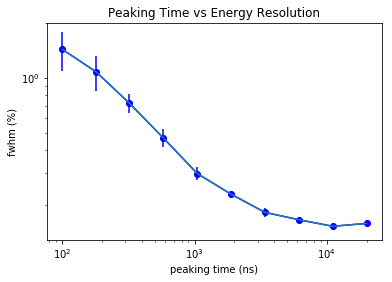

In [50]:
sys.exit()

[]


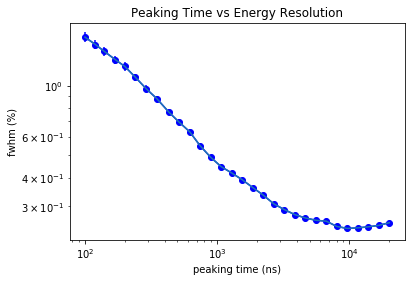

In [89]:
# OPTIMIZE PEAKING TIME

k_values = np.logspace(np.log10(10), np.log10(2000), 30, endpoint=True, base=10)
number_of_events = len(cs_raw_data)
assert number_of_events <= len(cs_raw_data)

k_fwhm_values = []
k_fwhm_values_err = []
k_fwhm_pulser_values = []
k_values_ns = []

nbins = 2048

for k in k_values:
    k = int(k)
    k_values_ns.append(k * 10)
    
    cs_nrgs=[]
    cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
    
    cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0,512])
    cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    cs_bins = cs_bins[1000:2000]
    cs_counts = cs_counts[1000:2000]
   # plt.plot(cs_bins, cs_counts)
   # plt.show()
    cs_peak_fwhm, cs_peak_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)

    k_fwhm_values.append(round(cs_peak_fwhm / cs_peak_center, 7) * 100)
    k_fwhm_values_err.append(err)
    
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('peaking time (ns)')
plt.ylabel('fwhm (%)')
plt.loglog(k_values_ns, k_fwhm_values, 'o-b')
plt.errorbar(k_values_ns, k_fwhm_values, yerr=k_fwhm_values_err, ecolor='b')
plt.title('Peaking Time vs Energy Resolution')
plt.savefig('../figures/peak_optimization_cs137.pdf')
plt.show()

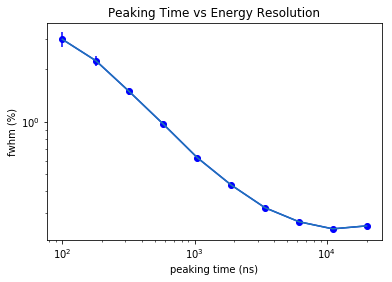

In [91]:
# OPTIMIZE PEAKING TIME

k_values = np.logspace(np.log10(10), np.log10(2000), 10, endpoint=True, base=10)
number_of_events = len(cs_raw_data)
assert number_of_events <= len(cs_raw_data)

k_fwhm_values = []
k_fwhm_values_err = []
k_fwhm_pulser_values = []
k_values_ns = []
m = 25

nbins = 2048

for k in k_values:
    k = int(k)
    k_values_ns.append(k * 10)
    
    cs_nrgs=[]
    cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
    
    cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0,512])
    cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    cs_bins = cs_bins[1000:2000]
    cs_counts = cs_counts[1000:2000]
   # plt.plot(cs_bins, cs_counts)
   # plt.show()
    cs_peak_fwhm, cs_peak_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)

    k_fwhm_values.append(round(cs_peak_fwhm / cs_peak_center, 7) * 100)
    k_fwhm_values_err.append(err * 100 / cs_peak_center)
    
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('peaking time (ns)')
plt.ylabel('fwhm (%)')
plt.loglog(k_values_ns, k_fwhm_values, 'o-b')
plt.errorbar(k_values_ns, k_fwhm_values, yerr=k_fwhm_values_err, ecolor='b')
plt.title('Peaking Time vs Energy Resolution')
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
#plt.savefig('../figures/peak_optimization_cs137.pdf')
plt.show()

In [93]:
print(min(k_fwhm_values))
print(np.argmin(k_fwhm_values))
print(k_values_ns[np.argmin(k_fwhm_values)])

0.24336
8
11100


[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 75
    # data points      = 1000
    # variables        = 5
    chi-square         = 11088.085
    reduced chi-square = 11.144
    Akaike info crit   = 2415.871
    Bayesian info crit = 2440.410
[[Variables]]
    lin_slope:      -0.03111605 +/- 0.001473 (4.74%) (init=-0.0402567)
    lin_intercept:   15.0674247 +/- 0.568669 (3.77%) (init= 20.58326)
    g1_sigma:        5.76906449 +/- 0.120989 (2.10%) (init= 1)
    g1_center:       352.200524 +/- 0.118023 (0.03%) (init= 350)
    g1_amplitude:    522.024046 +/- 9.939171 (1.90%) (init= 64)
    g1_fwhm:         13.5851084 +/- 0.284908 (2.10%)  == '2.3548200*g1_sigma'
    g1_height:       36.0990025 +/- 0.644758 (1.79%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.980 
    C(g1_sigma, g1_amplitude)    =  0.605 



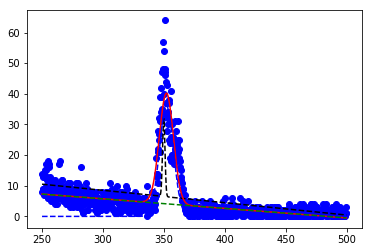

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 69
    # data points      = 1000
    # variables        = 5
    chi-square         = 13408.780
    reduced chi-square = 13.476
    Akaike info crit   = 2605.910
    Bayesian info crit = 2630.448
[[Variables]]
    lin_slope:      -0.03698877 +/- 0.001609 (4.35%) (init=-0.03986092)
    lin_intercept:   17.5588018 +/- 0.617222 (3.52%) (init= 20.86184)
    g1_sigma:        4.83727248 +/- 0.095204 (1.97%) (init= 1)
    g1_center:       368.279790 +/- 0.093447 (0.03%) (init= 365)
    g1_amplitude:    556.496720 +/- 9.832192 (1.77%) (init= 65)
    g1_fwhm:         11.3909059 +/- 0.224189 (1.97%)  == '2.3548200*g1_sigma'
    g1_height:       45.8957154 +/- 0.772549 (1.68%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.980 
    C(g1_sigma, g1_amplitude)    =  0.598 



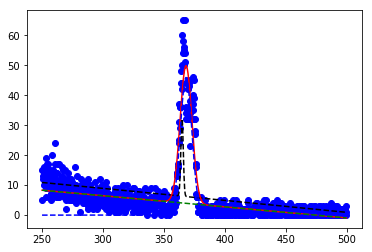

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 63
    # data points      = 1000
    # variables        = 5
    chi-square         = 14502.792
    reduced chi-square = 14.576
    Akaike info crit   = 2684.341
    Bayesian info crit = 2708.880
[[Variables]]
    lin_slope:      -0.03901656 +/- 0.001672 (4.29%) (init=-0.03905476)
    lin_intercept:   18.5270330 +/- 0.639220 (3.45%) (init= 20.72953)
    g1_sigma:        1.47117558 +/- 0.016669 (1.13%) (init= 1)
    g1_center:       374.909086 +/- 0.016580 (0.00%) (init= 375)
    g1_amplitude:    547.044565 +/- 5.424785 (0.99%) (init= 162)
    g1_fwhm:         3.46435369 +/- 0.039253 (1.13%)  == '2.3548200*g1_sigma'
    g1_height:       148.343419 +/- 1.450470 (0.98%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.981 
    C(g1_sigma, g1_amplitude)    =  0.583 



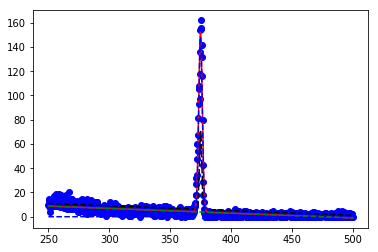

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 45
    # data points      = 1000
    # variables        = 5
    chi-square         = 8257.427
    reduced chi-square = 8.299
    Akaike info crit   = 2121.113
    Bayesian info crit = 2145.652
[[Variables]]
    lin_slope:      -0.03897869 +/- 0.001262 (3.24%) (init=-0.03868585)
    lin_intercept:   18.4962351 +/- 0.482174 (2.61%) (init= 20.6242)
    g1_sigma:        0.75172263 +/- 0.004480 (0.60%) (init= 1)
    g1_center:       375.681572 +/- 0.004468 (0.00%) (init= 375)
    g1_amplitude:    559.443844 +/- 2.903090 (0.52%) (init= 309)
    g1_fwhm:         1.77017148 +/- 0.010550 (0.60%)  == '2.3548200*g1_sigma'
    g1_height:       296.899154 +/- 1.529696 (0.52%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.982 
    C(g1_sigma, g1_amplitude)    =  0.580 



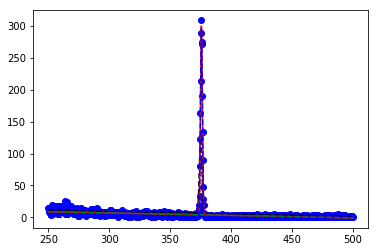

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 45
    # data points      = 1000
    # variables        = 5
    chi-square         = 7373.297
    reduced chi-square = 7.410
    Akaike info crit   = 2007.865
    Bayesian info crit = 2032.404
[[Variables]]
    lin_slope:      -0.03890373 +/- 0.001192 (3.07%) (init=-0.03860346)
    lin_intercept:   18.4719031 +/- 0.455629 (2.47%) (init= 20.5963)
    g1_sigma:        0.74509351 +/- 0.004179 (0.56%) (init= 1)
    g1_center:       375.699112 +/- 0.004167 (0.00%) (init= 375)
    g1_amplitude:    559.249252 +/- 2.730944 (0.49%) (init= 305)
    g1_fwhm:         1.75456111 +/- 0.009840 (0.56%)  == '2.3548200*g1_sigma'
    g1_height:       299.436483 +/- 1.451882 (0.48%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.982 
    C(g1_sigma, g1_amplitude)    =  0.580 



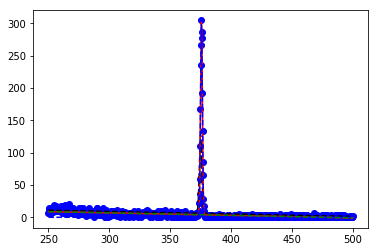

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 1000
    # variables        = 5
    chi-square         = 9375.141
    reduced chi-square = 9.422
    Akaike info crit   = 2248.062
    Bayesian info crit = 2272.600
[[Variables]]
    lin_slope:      -0.03883923 +/- 0.001345 (3.46%) (init=-0.03854173)
    lin_intercept:   18.4636549 +/- 0.513767 (2.78%) (init= 20.57515)
    g1_sigma:        0.72307597 +/- 0.004532 (0.63%) (init= 1)
    g1_center:       375.696992 +/- 0.004521 (0.00%) (init= 375)
    g1_amplitude:    555.764101 +/- 3.032845 (0.55%) (init= 329)
    g1_fwhm:         1.70271377 +/- 0.010674 (0.63%)  == '2.3548200*g1_sigma'
    g1_height:       306.631412 +/- 1.661828 (0.54%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.982 
    C(g1_sigma, g1_amplitude)    =  0.580 



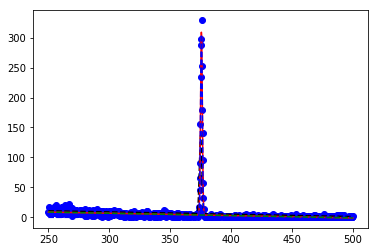

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 1000
    # variables        = 5
    chi-square         = 7822.140
    reduced chi-square = 7.861
    Akaike info crit   = 2066.958
    Bayesian info crit = 2091.497
[[Variables]]
    lin_slope:      -0.03874552 +/- 0.001228 (3.17%) (init=-0.03845049)
    lin_intercept:   18.4211395 +/- 0.469290 (2.55%) (init= 20.54093)
    g1_sigma:        0.73125325 +/- 0.004197 (0.57%) (init= 1)
    g1_center:       375.688957 +/- 0.004186 (0.00%) (init= 375)
    g1_amplitude:    557.608372 +/- 2.786161 (0.50%) (init= 311)
    g1_fwhm:         1.72196979 +/- 0.009883 (0.57%)  == '2.3548200*g1_sigma'
    g1_height:       304.208650 +/- 1.509471 (0.50%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.982 
    C(g1_sigma, g1_amplitude)    =  0.580 



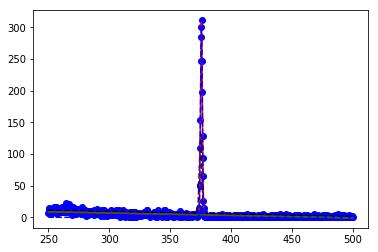

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 1000
    # variables        = 5
    chi-square         = 7647.847
    reduced chi-square = 7.686
    Akaike info crit   = 2044.424
    Bayesian info crit = 2068.963
[[Variables]]
    lin_slope:      -0.03881341 +/- 0.001214 (3.13%) (init=-0.03851245)
    lin_intercept:   18.4395778 +/- 0.464033 (2.52%) (init= 20.57017)
    g1_sigma:        0.73991410 +/- 0.004199 (0.57%) (init= 1)
    g1_center:       375.698707 +/- 0.004188 (0.00%) (init= 375)
    g1_amplitude:    560.863485 +/- 2.771477 (0.49%) (init= 315)
    g1_fwhm:         1.74236454 +/- 0.009889 (0.57%)  == '2.3548200*g1_sigma'
    g1_height:       302.402895 +/- 1.483818 (0.49%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.982 
    C(g1_sigma, g1_amplitude)    =  0.580 



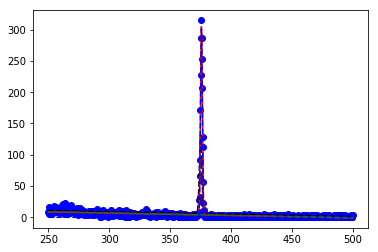

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 1000
    # variables        = 5
    chi-square         = 7991.658
    reduced chi-square = 8.032
    Akaike info crit   = 2088.398
    Bayesian info crit = 2112.937
[[Variables]]
    lin_slope:      -0.03893023 +/- 0.001241 (3.19%) (init=-0.03862329)
    lin_intercept:   18.4744229 +/- 0.474351 (2.57%) (init= 20.61373)
    g1_sigma:        0.75166646 +/- 0.004374 (0.58%) (init= 1)
    g1_center:       375.709125 +/- 0.004362 (0.00%) (init= 375)
    g1_amplitude:    563.603340 +/- 2.855870 (0.51%) (init= 303)
    g1_fwhm:         1.77003921 +/- 0.010301 (0.58%)  == '2.3548200*g1_sigma'
    g1_height:       299.128967 +/- 1.504926 (0.50%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.982 
    C(g1_sigma, g1_amplitude)    =  0.580 



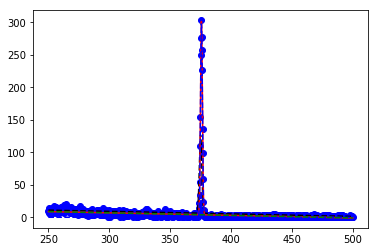

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(linear, prefix='lin_'))
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 1000
    # variables        = 5
    chi-square         = 7929.731
    reduced chi-square = 7.970
    Akaike info crit   = 2080.619
    Bayesian info crit = 2105.158
[[Variables]]
    lin_slope:      -0.03899948 +/- 0.001236 (3.17%) (init=-0.03869241)
    lin_intercept:   18.5027784 +/- 0.472511 (2.55%) (init= 20.64365)
    g1_sigma:        0.76140436 +/- 0.004439 (0.58%) (init= 1)
    g1_center:       375.708931 +/- 0.004427 (0.00%) (init= 375)
    g1_amplitude:    564.007198 +/- 2.863455 (0.51%) (init= 289)
    g1_fwhm:         1.79297023 +/- 0.010454 (0.58%)  == '2.3548200*g1_sigma'
    g1_height:       295.514891 +/- 1.489486 (0.50%)  == '0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'
[[Correlations]] (unreported correlations are <  0.500)
    C(lin_slope, lin_intercept)  = -0.982 
    C(g1_sigma, g1_amplitude)    =  0.580 



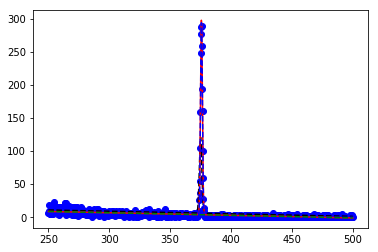

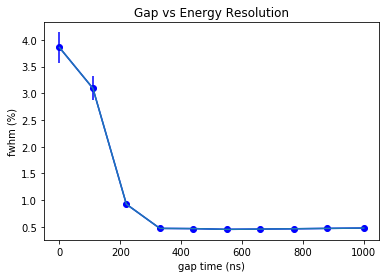

In [96]:
# OPTIMIZE GAP TIME

m_values = np.linspace(0, 100, 30)
k = 100

number_of_events = len(cs_raw_data)
#number_of_events = 10000
assert number_of_events <= len(cs_raw_data)
ndata = 4096

m_fwhm_values = []
m_values_ns = []
m_fwhm_values_err = []

for m in m_values:
    m = int(m)
    m_values_ns.append(m * 10)
    
    cs_nrgs=[]
    cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
    nbins = 2048
    cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0,512]) #, range=Cs_range) # WORKS
    cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    cs_fwhm, cs_center, err = fit_gaussian_peak_linear_background(cs_bins[1000:2000], cs_counts[1000:2000])
    m_fwhm_values_err.append(err* 100 / cs_peak_center)
    m_fwhm_values.append(round(cs_fwhm / cs_center, 7) * 100)
    
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (%)')
plt.errorbar(m_values_ns, m_fwhm_values, yerr=m_fwhm_values_err, ecolor='b')
plt.plot(m_values_ns, m_fwhm_values, 'o-b')
plt.title('Gap vs Energy Resolution')
plt.savefig('../figures/gap_optimization_cs.pdf')
# plt.show()

plt.figure()
plt.cla()
plt.clf()
m_diff_list = abs(np.diff(m_fwhm_values))
plt.plot(m_values_ns[0:-1], m_diff_list, '-')
# plt.show()

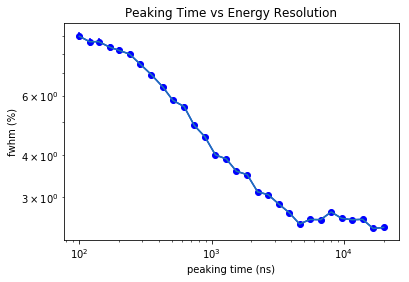

In [90]:
# OPTIMIZE PEAKING TIME

k_values = np.logspace(np.log10(10), np.log10(2000), 30, endpoint=True, base=10)
number_of_events = len(am_raw_data)
assert number_of_events <= len(am_raw_data)

k_fwhm_values = []
k_fwhm_values_err = []
k_fwhm_pulser_values = []
k_values_ns = []

nbins = 2048

for k in k_values:
    k = int(k)
    k_values_ns.append(k * 10)
    
    am_nrgs=[]
    am_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, am_baseline_corrected_signals, k, m, M)
    am_counts, bin_edges = np.histogram(am_nrgs, bins=2048, range=[0,1024])
    am_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    #plt.plot(am_bins, am_counts)
    #plt.show()
    am_bins = am_bins[10:100] 
    am_counts = am_counts[10:100]
    #plt.plot(am_bins, am_counts)
    #plt.show()
    peak_fwhm, peak_center ,err = fit_gaussian_peak_linear_background(am_bins, am_counts)

    k_fwhm_values.append(round(peak_fwhm / peak_center, 7) * 100)
    k_fwhm_values_err.append(err)
    
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('peaking time (ns)')
plt.ylabel('fwhm (%)')
plt.errorbar(k_values_ns, k_fwhm_values, yerr=k_fwhm_values_err, ecolor='b')
plt.loglog(k_values_ns, k_fwhm_values, 'o-b')
plt.title('Peaking Time vs Energy Resolution')
plt.savefig('../figures/peak_optimization.pdf')
plt.show()

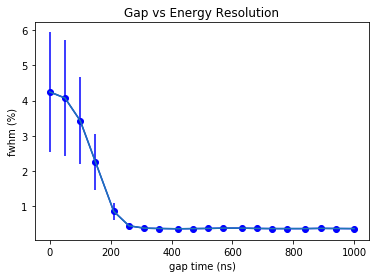

In [45]:
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (%)')
plt.errorbar(m_values_ns, m_fwhm_values, yerr=m_fwhm_values_err, ecolor='b')
plt.plot(m_values_ns, m_fwhm_values, 'o-b')
plt.title('Gap vs Energy Resolution')
plt.savefig('../figures/gap_optimization_co.pdf')
# plt.show()

plt.figure()
plt.cla()
plt.clf()
m_diff_list = abs(np.diff(m_fwhm_values))
plt.plot(m_values_ns[0:-1], m_diff_list, '-')
# plt.show()